In [3]:
import os
import requests
import re
import scrapy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.impute import KNNImputer

# Part 1: Crawlers

In [2]:
#Use this to test xpath/regex
from scrapy.http import TextResponse

# Test URLs:
url1 = 'https://boardgamegeek.com/browse/boardgame/page/1'
url2 = 'https://boardgamegeek.com/browse/boardgame/page/191'
url3 = 'https://boardgamegeek.com/boardgame/174430/gloomhaven/credits'

r = requests.get(url3)
response = TextResponse(r.url, body=r.text, encoding='utf-8')
response

<200 https://boardgamegeek.com/boardgame/174430/gloomhaven/credits>

In [111]:
# dont forget to close the request!
r.close()

In [2]:
# create class item used to structure data extracted by scrapy
# save this in items.py

import scrapy

class BrowseItem(scrapy.Item):
    board_game_rank = scrapy.Field()
    title = scrapy.Field()
    game_sub_url = scrapy.Field()
    geek_rating = scrapy.Field()
    avg_rating = scrapy.Field()
    num_voters = scrapy.Field()
    pass

class CreditItem(scrapy.Item):
    url = scrapy.Field()
    min_players = scrapy.Field()
    max_players = scrapy.Field()
    min_play_time = scrapy.Field()
    max_play_time = scrapy.Field()
    age = scrapy.Field()
    weight = scrapy.Field()
    #category = scrapy.Field()
    #mechanisms = scrapy.Field()
    #family = scrapy.Field()
    pass

In [8]:
# save the below in BrowseSpider.py
# extracts ranking data and game page URLs from boardgamegeek.com/browse for all ranked games

import scrapy
from Capstone.items import BrowseItem
import requests

class BrowseSpider(scrapy.Spider):
    name = "browse"

    def start_requests(self):
        urls = ['https://boardgamegeek.com/browse/boardgame/page/1']
        
        # scrapes npages - will work up through page 191 until N/A values become present
        npages = 1

        for i in range(1, npages):
            urls.append("https://boardgamegeek.com/browse/boardgame/page/"+str(i+1)+"")

        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)

    def parse(self, response):
            n = 0
            y = 0
            while n < 100:
            # each page has 100 board games - this loop ensures all 100 are gathered before going to the next page
                for sel in response.xpath('//table'):
                    item = BrowseItem()
                    item['board_game_rank'] = response.xpath('//tr/td/a[@name]')[n].extract()
                    item['title'] = response.xpath('//tr/td/div/a[@href]/text()')[n].extract()
                    item['game_sub_url'] = response.xpath('//tr/td/div/a/@href')[n].extract()
                    # geek_rating, avg_rating, num_voters all have the same xpath
                    # so y is incremented seperately to collect these fields with their coresponding game
                    item['geek_rating'] = response.xpath('//tr/td[contains(@class,"collection_bggrating")]/text()')[y].extract()
                    item['avg_rating'] = response.xpath('//tr/td[contains(@class,"collection_bggrating")]/text()')[y+1].extract()
                    item['num_voters'] = response.xpath('//tr/td[contains(@class,"collection_bggrating")]/text()')[y+2].extract()
                    n += 1
                    y += 3
                    yield item

# use this command to execute this spider in the command line and save data to csv
#scrapy crawl browse -o browse_raw.csv

In [ ]:
# save below into CreditSpider.py

import scrapy
from Capstone.items import CreditItem
import requests
import re
import pandas as pd

min_players_pattern = r'minplayers":"\d*'
max_players_pattern = r'maxplayers":"\d*'
min_play_time_pattern = r'minplaytime":"\d*'
max_play_time_pattern = r'maxplaytime":"\d*'
age_pattern = r'minage":"\d*'
weight_dec_pattern = r'"averageweight":\d\.\d*'
weight_pattern = r'"averageweight":\d'
#mechanisms_pattern = r'\\/boardgamemechanic\\/([^\"]+)'
#category_pattern = r'\\/boardgamecategory\\/([^\"]+)'
#family_pattern = r'\\/boardgamefamily\\/([^\"]+)'

df = pd.read_csv('browse_split1.csv')
s = df.full_game_url

class CreditSpider(scrapy.Spider):
    name = "credit"

    def start_requests(self):
        urls = s.tolist()
        
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
            
    def parse(self, response):
        item = CreditItem()
        item['url'] = response.url
        item['min_players'] = re.findall(min_players_pattern, response.text)
        item['max_players'] = re.findall(max_players_pattern, response.text)
        item['min_play_time'] = re.findall(min_play_time_pattern, response.text)
        item['max_play_time'] = re.findall(max_play_time_pattern, response.text)
        item['age'] = re.findall(age_pattern, response.text)
        if re.findall(weight_dec_pattern, response.text) != []:
            item['weight'] = re.findall(weight_dec_pattern, response.text)
        else:
            item['weight'] = re.findall(weight_pattern, response.text)
        #item['category'] = re.findall(category_pattern, response.text)
        #item['mechanisms'] = re.findall(mechanisms_pattern, response.text)
        #item['family'] = re.findall(family_pattern, response.text)
        yield item

# use this command to execute this spider in the command line and save data to csv
#scrapy crawl credit -o credit.csv

In [ ]:
# the text fields, category, mechanism, and family, were not completely captured by the credit spider
# Selenium is used because it is able to pull the final rendered information

from selenium import webdriver
from selenium.webdriver.firefox.options import Options
import pandas as pd
import numpy as np


url_df = pd.read_csv('browse_clean.csv')

url_df = url_df.dropna()

# the script was locking up my machine and timing out after ~200 urls
# splitting the URLs into smaller buckets alleviated this and allowed for incremental output
url_s = url_df.full_game_url
url_split = np.array_split(url_s, 160)

n = 0

for array in url_split:
    urls = array.tolist()
    cmf_df = pd.DataFrame(columns = ['url', 'category', 'mechanic', 'family'])
    
    options = Options()
    options.headless = True

    driver = webdriver.Firefox(options=options, executable_path= r'C:\Users\Sam\Desktop\Capstone\Selenium\geckodriver.exe')
    driver.implicitly_wait(5) # implement 5 second wait per robots.txt
    print ("Headless Firefox Initialized")
    

    for url in urls:        
        driver.get(url)
        print('current url is: ' + str(url))
    
        url_list = []
        url_list.append(url)
    
        category_list = []
        board_game_category = driver.find_elements_by_xpath('//a[contains(@href, "/boardgamecategory/")]')
        for category in board_game_category:
            category_list.append(category.text)
    
        mechanic_list = []
        board_game_mechanic = driver.find_elements_by_xpath('//a[contains(@href, "/boardgamemechanic/")]')
        for mechanic in board_game_mechanic:
            mechanic_list.append(mechanic.text)
    
        family_list = []
        board_game_family = driver.find_elements_by_xpath('//a[contains(@href, "/boardgamefamily/")]')
        for family in board_game_family:
            family_list.append(family.text)
    
        cmf_df = cmf_df.append({'url':url_list, 'category':category_list, 'mechanic':mechanic_list, 'family':family_list}, ignore_index=True)
    cmf_df.to_csv('cmf' + str(n) + '.csv')
    n += 1

    driver.close()

# run this from command line like regular .py script

# Part 2: Merging & Cleaning Data 

### A) Clean Browse Data

In [28]:
browse = pd.read_csv('browse_raw.csv')
browse.head()

,avg_rating,board_game_rank,game_sub_url,geek_rating,num_voters,title
0,8.83,"<a name=""1""></a>",/boardgame/174430/gloomhaven,8.573,35473,Gloomhaven
1,8.62,"<a name=""2""></a>",/boardgame/161936/pandemic-legacy-season-1,8.472,37381,Pandemic Legacy: Season 1
2,7.45,"<a name=""201""></a>",/boardgame/38453/space-alert,7.247,14338,Space Alert
3,7.30,"<a name=""701""></a>",/boardgame/95064/ascension-return-fallen,6.695,3080,Ascension: Return of the Fallen
4,7.29,"<a name=""401""></a>",/boardgame/221965/fox-forest,6.969,6974,The Fox in the Forest


In [63]:
# gut check numerical values make sense and that there is the correct number of records
browse.describe()

,avg_rating,geek_rating,num_voters
count,19021.000000,19021.000000,19021.000000
mean,6.386351,5.690198,813.579465
std,0.926287,0.370845,3331.389788
min,1.050000,3.537000,30.000000
25%,5.800000,5.511000,55.000000
50%,6.420000,5.551000,120.000000
75%,7.000000,5.689000,379.000000
max,9.690000,8.573000,94727.000000


In [29]:
# Creates a column 'full_game_url' to extract a list of urls to be used with the credit spider
browse['full_game_url'] = 'https://boardgamegeek.com' + browse['game_sub_url'].astype(str) + "/credits"

In [46]:
# extracts numerical rank from column board_game_rank
def clean_rank(rank):
    return re.findall(r'\d+', rank)[0]

browse['board_game_rank_clean'] = browse['board_game_rank'].apply(clean_rank)

# converts numerical rank from object type to int64
browse = browse.astype({'board_game_rank_clean' : 'int64'})

# sorts df by board_game_rank_clean and sets index to the same
browse.sort_values(by='board_game_rank_clean', ignore_index=True, inplace=True)

# rename board_game_rank column
browse.rename(columns={'board_game_rank_clean':'rank'}, inplace=True)

# drop unessesary columns
browse.drop('board_game_rank', axis=1, inplace=True)
browse.drop('game_sub_url', axis=1, inplace=True)

In [101]:
browse.head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank
0,8.83,8.573,35473,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,1
1,8.62,8.472,37381,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2
2,8.64,8.279,13199,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,3
3,8.43,8.277,54788,Terraforming Mars,https://boardgamegeek.com/boardgame/167791/ter...,4
4,8.47,8.219,20264,Through the Ages: A New Story of Civilization,https://boardgamegeek.com/boardgame/182028/thr...,5


In [102]:
browse.to_csv('browse_clean.csv')

### B) Extract URLs from browse for second crawl

In [110]:
# drop columns not needed for the next scrape and 
# split browse into smaller files so I don't have to scrape 20,000 pages all at once

browse_split = browse.drop(['avg_rating','geek_rating','num_voters','title'], axis=1)

browse_split = np.array_split(browse_split, 10)

n = 1
for df in browse_split:
    df.to_csv('browse_split'+str(n)+'.csv')
    n += 1

In [65]:
# import credit spider raw data and save into one file
credits = pd.DataFrame()

df_list = []
for file in range(1,11):
    df_list.append(pd.read_csv('credit'+str(file)+'.csv'))

credits = pd.concat(df_list)
credits.to_csv('credits_first_run.csv')

In [70]:
browse = pd.read_csv('browse_clean.csv', index_col=0)

Some data was missed in the first run of my credits script due to:

1) The regex pattern did not always collect weight as some had decimals and others did not (this is updated in the current script)

2) Occasinally a crawl would miss 1-2 records

3) My internet went down during one of the crawls

The below identifies these urls and seperates them for another crawl

In [76]:
# merge browse_clean and credit first run data 
browse_merge = browse.merge(credits, how = 'left', left_on = 'full_game_url', right_on = 'url')

# identify null values
browse_null = browse_merge[browse_merge.isnull().any(axis=1)]

browse_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4757 entries, 224 to 17118
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   avg_rating     4757 non-null   float64
 1   geek_rating    4757 non-null   float64
 2   num_voters     4757 non-null   int64  
 3   title          4757 non-null   object 
 4   full_game_url  4757 non-null   object 
 5   rank           4757 non-null   int64  
 6   age            3321 non-null   object 
 7   max_play_time  3321 non-null   object 
 8   max_players    3321 non-null   object 
 9   min_play_time  3321 non-null   object 
 10  min_players    3321 non-null   object 
 11  url            3321 non-null   object 
 12  weight         0 non-null      object 
dtypes: float64(2), int64(2), object(9)
memory usage: 520.3+ KB


In [87]:
null_urls = browse_null.full_game_url
null_urls.to_csv('null_urls.csv')

### C) Cleaning Selenium and Merging With Scrapy Browse

In [3]:
cmf = pd.DataFrame()

df_list = []
for file in range(0,160):
    df_list.append(pd.read_csv('cmf'+str(file)+'.csv', index_col=0))

cmf = pd.concat(df_list)
cmf.to_csv('cmf_raw.csv')

In [138]:
cmf = pd.read_csv('cmf_raw.csv', index_col=0)

In [139]:
cmf.head()

,url,category,mechanic,family
0,['https://boardgamegeek.com/boardgame/174430/g...,"['Adventure', 'Exploration', 'Fantasy', 'Fight...","['Action Retrieval', 'Campaign / Battle Card D...","['Components: Miniatures', 'Crowdfunding: Kick..."
1,['https://boardgamegeek.com/boardgame/161936/p...,"['Environmental', 'Medical']","['Action Points', 'Cooperative Game', 'Hand Ma...","['Game: Pandemic', 'Mechanic: Campaign Games',..."
2,['https://boardgamegeek.com/boardgame/224517/b...,"['Economic', 'Industry / Manufacturing', 'Tran...","['Connections', 'Hand Management', 'Income', '...","['Cities: Birmingham (England)', 'Country: Eng..."
3,['https://boardgamegeek.com/boardgame/167791/t...,"['Economic', 'Environmental', 'Industry / Manu...","['Card Drafting', 'End Game Bonuses', 'Hand Ma...","['Game: Terraforming Mars', 'Mechanic: Tableau..."
4,['https://boardgamegeek.com/boardgame/182028/t...,"['Card Game', 'Civilization', 'Economic']","['Action Points', 'Auction/Bidding', 'Auction:...","['Game: Through the Ages', 'Mechanic: Tableau ..."


In [140]:
# clean cmf data
def clean_cmf_col(cmf_col):
    return re.findall(r'\[(.*?)\]', cmf_col)

def clean_url_col(url_col):
    return re.findall(r"\'(.*?)\'", url_col)

cmf['url'] = cmf['url'].apply(clean_url_col).str[0]
cmf['category'] = cmf['category'].apply(clean_cmf_col).str[0]
cmf['mechanic'] = cmf['mechanic'].apply(clean_cmf_col).str[0]
cmf['family'] = cmf['family'].apply(clean_cmf_col).str[0]


In [141]:
cmf.head()

,url,category,mechanic,family
0,https://boardgamegeek.com/boardgame/174430/glo...,"'Adventure', 'Exploration', 'Fantasy', 'Fighti...","'Action Retrieval', 'Campaign / Battle Card Dr...","'Components: Miniatures', 'Crowdfunding: Kicks..."
1,https://boardgamegeek.com/boardgame/161936/pan...,"'Environmental', 'Medical'","'Action Points', 'Cooperative Game', 'Hand Man...","'Game: Pandemic', 'Mechanic: Campaign Games', ..."
2,https://boardgamegeek.com/boardgame/224517/bra...,"'Economic', 'Industry / Manufacturing', 'Trans...","'Connections', 'Hand Management', 'Income', 'L...","'Cities: Birmingham (England)', 'Country: Engl..."
3,https://boardgamegeek.com/boardgame/167791/ter...,"'Economic', 'Environmental', 'Industry / Manuf...","'Card Drafting', 'End Game Bonuses', 'Hand Man...","'Game: Terraforming Mars', 'Mechanic: Tableau ..."
4,https://boardgamegeek.com/boardgame/182028/thr...,"'Card Game', 'Civilization', 'Economic'","'Action Points', 'Auction/Bidding', 'Auction: ...","'Game: Through the Ages', 'Mechanic: Tableau B..."


In [148]:
cmf.to_csv('cmf_clean.csv')

In [21]:
cmf = pd.read_csv('cmf_clean.csv', index_col=0)

In [13]:
cmf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19021 entries, 0 to 117
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   url       19021 non-null  object
 1   category  18810 non-null  object
 2   mechanic  17453 non-null  object
 3   family    14406 non-null  object
dtypes: object(4)
memory usage: 743.0+ KB


In [22]:
browse = pd.read_csv('browse_clean.csv', index_col=0)

In [23]:
browse_cmf = browse.merge(cmf, how = 'left', left_on = 'full_game_url', right_on = 'url')

In [24]:
browse_cmf.head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,url,category,mechanic,family
0,8.83,8.573,35473,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,1,https://boardgamegeek.com/boardgame/174430/glo...,"'Adventure', 'Exploration', 'Fantasy', 'Fighti...","'Action Retrieval', 'Campaign / Battle Card Dr...","'Components: Miniatures', 'Crowdfunding: Kicks..."
1,8.62,8.472,37381,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2,https://boardgamegeek.com/boardgame/161936/pan...,"'Environmental', 'Medical'","'Action Points', 'Cooperative Game', 'Hand Man...","'Game: Pandemic', 'Mechanic: Campaign Games', ..."
2,8.64,8.279,13199,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,3,https://boardgamegeek.com/boardgame/224517/bra...,"'Economic', 'Industry / Manufacturing', 'Trans...","'Connections', 'Hand Management', 'Income', 'L...","'Cities: Birmingham (England)', 'Country: Engl..."
3,8.43,8.277,54788,Terraforming Mars,https://boardgamegeek.com/boardgame/167791/ter...,4,https://boardgamegeek.com/boardgame/167791/ter...,"'Economic', 'Environmental', 'Industry / Manuf...","'Card Drafting', 'End Game Bonuses', 'Hand Man...","'Game: Terraforming Mars', 'Mechanic: Tableau ..."
4,8.47,8.219,20264,Through the Ages: A New Story of Civilization,https://boardgamegeek.com/boardgame/182028/thr...,5,https://boardgamegeek.com/boardgame/182028/thr...,"'Card Game', 'Civilization', 'Economic'","'Action Points', 'Auction/Bidding', 'Auction: ...","'Game: Through the Ages', 'Mechanic: Tableau B..."


In [7]:
browse_cmf_null = browse_cmf[browse_cmf.isnull().any(axis=1)]

browse_cmf_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5677 entries, 107 to 19028
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   avg_rating     5677 non-null   float64
 1   geek_rating    5677 non-null   float64
 2   num_voters     5677 non-null   int64  
 3   title          5677 non-null   object 
 4   full_game_url  5677 non-null   object 
 5   rank           5677 non-null   int64  
 6   url            5677 non-null   object 
 7   category       5466 non-null   object 
 8   mechanic       4109 non-null   object 
 9   family         1062 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 487.9+ KB


In [8]:
browse_cmf_null.head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,url,category,mechanic,family
107,7.79,7.448,9133,Decrypto,https://boardgamegeek.com/boardgame/225694/dec...,108,https://boardgamegeek.com/boardgame/225694/dec...,"'Deduction', 'Party Game', 'Spies/Secret Agent...","'Communication Limits', 'Targeted Clues', 'Tea...",NaN
178,7.62,7.290,8166,Just One,https://boardgamegeek.com/boardgame/254640/jus...,179,https://boardgamegeek.com/boardgame/254640/jus...,"'Party Game', 'Word Game'","'Communication Limits', 'Cooperative Game'",NaN
196,8.07,7.254,3270,The Crew: The Quest for Planet Nine,https://boardgamegeek.com/boardgame/284083/cre...,197,https://boardgamegeek.com/boardgame/284083/cre...,"'Card Game', 'Science Fiction', 'Space Explora...","'Communication Limits', 'Cooperative Game', 'S...",NaN
215,7.75,7.226,5220,Pulsar 2849,https://boardgamegeek.com/boardgame/228341/pul...,216,https://boardgamegeek.com/boardgame/228341/pul...,"'Dice', 'Science Fiction', 'Space Exploration'","'Dice Rolling', 'Point to Point Movement', 'Va...",NaN
230,7.49,7.189,8698,Ethnos,https://boardgamegeek.com/boardgame/206718/eth...,231,https://boardgamegeek.com/boardgame/206718/eth...,'Fantasy',"'Area Majority / Influence', 'Card Drafting', ...",NaN


In [25]:
browse_cmf.to_csv('browse_cmf.csv')

### D) Clean credits data from both crawls

In [2]:
credits = pd.read_csv('credits_first_run.csv', index_col=0)
credits_null = pd.read_csv('null_crawl.csv')

In [3]:
def clean_num_col(num_col):
    return re.findall(r'\d+', num_col)

def clean_num_col_dec(num_col):
    if re.findall('\d\.\d+', str(num_col)) != []:
        return re.findall('\d\.\d+', str(num_col))
    else:
        return re.findall(r'\d+', num_col)

In [4]:
# clean credits_null

credits_null['age'] = credits_null['age'].apply(clean_num_col).str[0].astype(int)
credits_null['max_play_time'] = credits_null['max_play_time'].apply(clean_num_col).str[0].astype(int)
credits_null['max_players'] = credits_null['max_players'].apply(clean_num_col).str[0].astype(int)
credits_null['min_play_time'] = credits_null['min_play_time'].apply(clean_num_col).str[0].astype(int)
credits_null['min_players'] = credits_null['min_players'].apply(clean_num_col).str[0].astype(int)
credits_null['weight'] = credits_null['weight'].apply(clean_num_col_dec).str[0].astype(np.float16)

In [9]:
# clean credits

credits['age'] = credits['age'].apply(clean_num_col).str[0].astype(int)
credits['max_play_time'] = credits['max_play_time'].apply(clean_num_col).str[0].astype(int)
credits['max_players'] = credits['max_players'].apply(clean_num_col).str[0].astype(int)
credits['min_play_time'] = credits['min_play_time'].apply(clean_num_col).str[0].astype(int)
credits['min_players'] = credits['min_players'].apply(clean_num_col).str[0].astype(int)
credits['weight'] = credits['weight'].apply(str).apply(clean_num_col_dec).str[0].astype(np.float16)

In [10]:
credit_append = credits.append(credits_null)

In [11]:
# removing duplicates where the first record was incomplete
credits_append_dropdup = credit_append.drop_duplicates(subset='url', keep='last')

In [ ]:
# import null_urls df, try combine_first to merge updated values 
# put it on dataworld

In [12]:
credits_append_dropdup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19016 entries, 0 to 4756
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            19016 non-null  int32  
 1   max_play_time  19016 non-null  int32  
 2   max_players    19016 non-null  int32  
 3   min_play_time  19016 non-null  int32  
 4   min_players    19016 non-null  int32  
 5   url            19016 non-null  object 
 6   weight         19015 non-null  float16
dtypes: float16(1), int32(5), object(1)
memory usage: 705.7+ KB


In [14]:
credits_append_dropdup.head()

,age,max_play_time,max_players,min_play_time,min_players,url,weight
0,12,120,4,60,1,https://boardgamegeek.com/boardgame/174430/glo...,3.832031
1,13,60,4,60,2,https://boardgamegeek.com/boardgame/161936/pan...,2.830078
2,14,120,4,60,2,https://boardgamegeek.com/boardgame/224517/bra...,3.929688
3,12,120,5,120,1,https://boardgamegeek.com/boardgame/167791/ter...,3.236328
4,14,120,4,120,2,https://boardgamegeek.com/boardgame/182028/thr...,4.394531


In [15]:
credits_append_dropdup_null = credits_append_dropdup[credits_append_dropdup.isnull().any(axis=1)]

In [16]:
credits_append_dropdup_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 842 to 842
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1 non-null      int32  
 1   max_play_time  1 non-null      int32  
 2   max_players    1 non-null      int32  
 3   min_play_time  1 non-null      int32  
 4   min_players    1 non-null      int32  
 5   url            1 non-null      object 
 6   weight         0 non-null      float16
dtypes: float16(1), int32(5), object(1)
memory usage: 38.0+ bytes


In [17]:
credits_append_dropdup.to_csv('credits_clean.csv')

### D) Merge Credits, Browse, and CMF

In [18]:
credits_clean = pd.read_csv('credits_clean.csv', index_col=0)
browse_cmf = pd.read_csv('browse_cmf.csv', index_col=0)

In [19]:
browse_credit_cmf = browse_cmf.merge(credits_clean, how = 'left', left_on = 'url', right_on = 'url')

In [20]:
browse_credit_cmf.head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,url,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
0,8.83,8.573,35473,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,1,https://boardgamegeek.com/boardgame/174430/glo...,"'Adventure', 'Exploration', 'Fantasy', 'Fighti...","'Action Retrieval', 'Campaign / Battle Card Dr...","'Components: Miniatures', 'Crowdfunding: Kicks...",12.0,120.0,4.0,60.0,1.0,3.832
1,8.62,8.472,37381,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2,https://boardgamegeek.com/boardgame/161936/pan...,"'Environmental', 'Medical'","'Action Points', 'Cooperative Game', 'Hand Man...","'Game: Pandemic', 'Mechanic: Campaign Games', ...",13.0,60.0,4.0,60.0,2.0,2.830
2,8.64,8.279,13199,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,3,https://boardgamegeek.com/boardgame/224517/bra...,"'Economic', 'Industry / Manufacturing', 'Trans...","'Connections', 'Hand Management', 'Income', 'L...","'Cities: Birmingham (England)', 'Country: Engl...",14.0,120.0,4.0,60.0,2.0,3.930
3,8.43,8.277,54788,Terraforming Mars,https://boardgamegeek.com/boardgame/167791/ter...,4,https://boardgamegeek.com/boardgame/167791/ter...,"'Economic', 'Environmental', 'Industry / Manuf...","'Card Drafting', 'End Game Bonuses', 'Hand Man...","'Game: Terraforming Mars', 'Mechanic: Tableau ...",12.0,120.0,5.0,120.0,1.0,3.236
4,8.47,8.219,20264,Through the Ages: A New Story of Civilization,https://boardgamegeek.com/boardgame/182028/thr...,5,https://boardgamegeek.com/boardgame/182028/thr...,"'Card Game', 'Civilization', 'Economic'","'Action Points', 'Auction/Bidding', 'Auction: ...","'Game: Through the Ages', 'Mechanic: Tableau B...",14.0,120.0,4.0,120.0,2.0,4.395


In [21]:
browse_credit_cmf.to_csv('bgg_raw.csv')

# Part 3: Dealing With NaN and Outliers

In [127]:
bgg_raw = pd.read_csv('BGG_raw.csv', index_col=0)

In [128]:
bgg_raw.drop('full_game_url', axis=1, inplace=True)

In [28]:
# pulling a sample to confirm data has mapped correctly - ranks have already changed (slightly) in the past 10 days!
bgg_raw.sample(10)

,avg_rating,geek_rating,num_voters,title,rank,url,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
10503,6.30,5.540,87,Grand Prix,10492,https://boardgamegeek.com/boardgame/573/grand-...,"'Abstract Strategy', 'Racing'",NaN,'Sports: Auto Racing',8.0,60.0,6.0,60.0,3.0,1.363
8093,7.47,5.571,65,Bestiary of Sigillum,8082,https://boardgamegeek.com/boardgame/172484/bes...,"'Abstract Strategy', 'Fantasy'","'Area Majority / Influence', 'Grid Movement', ...",'Sigillum universe',14.0,80.0,2.0,30.0,2.0,3.334
6472,5.93,5.610,499,Flandern 1302,6461,https://boardgamegeek.com/boardgame/13729/flan...,'Medieval',"'Area Majority / Influence', 'Simultaneous Act...",'Country: Belgium',8.0,60.0,4.0,60.0,2.0,2.342
4023,6.84,5.748,324,A Thief's Fortune,4012,https://boardgamegeek.com/boardgame/254110/thi...,"'Arabian', 'Card Game', 'Fantasy'",'Card Drafting',"'Admin: Better Description Needed!', 'Crowdfun...",12.0,90.0,4.0,45.0,1.0,2.777
1774,8.29,6.160,514,The U.S. Civil War,1771,https://boardgamegeek.com/boardgame/162009/us-...,"'American Civil War', 'Civil War', 'Post-Napol...","'Dice Rolling', 'Grid Movement', 'Hexagon Grid...","'Country: USA', 'Players: Two Player Only Games'",0.0,360.0,2.0,150.0,2.0,3.836
11771,6.23,5.529,78,Expedition Zetta,11760,https://boardgamegeek.com/boardgame/184247/exp...,"'Science Fiction', 'Space Exploration'","'Auction/Bidding', 'Card Drafting', 'Grid Move...",'Crowdfunding: Kickstarter',10.0,180.0,5.0,30.0,1.0,3.166
15482,5.59,5.502,31,The Hobbit: An Unexpected Journey – Das Karten...,15471,https://boardgamegeek.com/boardgame/130626/hob...,"'Card Game', 'Fantasy', 'Movies / TV / Radio t...","'Area Majority / Influence', 'Hand Management'","'Admin: Better Description Needed!', 'Authors:...",8.0,30.0,4.0,30.0,2.0,2.000
9006,7.73,5.557,49,Battlegroup: Kursk,8995,https://boardgamegeek.com/boardgame/128154/bat...,"'Book', 'Miniatures', 'Wargame', 'World War II'","'Action Points', 'Chit-Pull System', 'Dice Rol...",'Series: Battlegroup Rules',12.0,0.0,0.0,120.0,2.0,3.334
15272,5.80,5.503,36,Asia Crossroads,15261,https://boardgamegeek.com/boardgame/7040/asia-...,"'Post-Napoleonic', 'Wargame'",'Square Grid',"'Admin: Better Description Needed!', 'Country:...",NaN,NaN,NaN,NaN,NaN,NaN
3938,6.69,5.755,395,Kosmonauts,3927,https://boardgamegeek.com/boardgame/117854/kos...,'Science Fiction',"'Action Queue', 'Hexagon Grid'","""Space: Earth's Solar System""",8.0,60.0,4.0,60.0,2.0,2.172


In [25]:
bgg_raw.describe()

,avg_rating,geek_rating,num_voters,rank,age,max_play_time,max_players,min_play_time,min_players,weight
count,19033.000000,19033.000000,19033.000000,19033.000000,19007.000000,19007.000000,19007.000000,19007.000000,19007.000000,19006.000000
mean,6.386941,5.690499,814.345610,9506.212368,9.594097,96.930868,5.606250,67.085653,2.031357,1.996283
std,0.926443,0.370991,3331.152616,5492.636028,3.629719,1033.583525,15.411892,476.346480,0.682970,0.848838
min,1.050000,3.537000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.800000,5.511000,55.000000,4747.000000,8.000000,30.000000,4.000000,20.000000,2.000000,1.333000
50%,6.420000,5.551000,120.000000,9505.000000,10.000000,45.000000,4.000000,30.000000,2.000000,1.972500
75%,7.000000,5.690000,380.000000,14263.000000,12.000000,90.000000,6.000000,60.000000,2.000000,2.555000
max,9.690000,8.573000,94727.000000,19021.000000,25.000000,120000.000000,999.000000,60000.000000,10.000000,5.000000


In [26]:
bgg_raw_null = bgg_raw[bgg_raw.isnull().any(axis=1)]

In [27]:
# category, family and mechanic are not always present in the data so number of nulls is not surprising
bgg_raw_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5703 entries, 107 to 19028
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   avg_rating     5703 non-null   float64
 1   geek_rating    5703 non-null   float64
 2   num_voters     5703 non-null   int64  
 3   title          5703 non-null   object 
 4   rank           5703 non-null   int64  
 5   url            5703 non-null   object 
 6   category       5492 non-null   object 
 7   mechanic       4135 non-null   object 
 8   family         1088 non-null   object 
 9   age            5677 non-null   float64
 10  max_play_time  5677 non-null   float64
 11  max_players    5677 non-null   float64
 12  min_play_time  5677 non-null   float64
 13  min_players    5677 non-null   float64
 14  weight         5676 non-null   float64
dtypes: float64(8), int64(2), object(5)
memory usage: 712.9+ KB


In [60]:
# trying to find where age, min/max players, min/max playtime, weight are null
age_bool = bgg_raw['age'].isna()
subset_null = bgg_raw[age_bool]
subset_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 858 to 17008
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   avg_rating     26 non-null     float64
 1   geek_rating    26 non-null     float64
 2   num_voters     26 non-null     int64  
 3   title          26 non-null     object 
 4   rank           26 non-null     int64  
 5   url            26 non-null     object 
 6   category       26 non-null     object 
 7   mechanic       26 non-null     object 
 8   family         26 non-null     object 
 9   age            0 non-null      float64
 10  max_play_time  0 non-null      float64
 11  max_players    0 non-null      float64
 12  min_play_time  0 non-null      float64
 13  min_players    0 non-null      float64
 14  weight         0 non-null      float64
dtypes: float64(8), int64(2), object(5)
memory usage: 3.2+ KB


In [61]:
# looks like its just 26 entries - extracting and scraping again
subset_null['url'].to_csv('null_urls2.csv')

In [169]:
null_crawl2 = pd.read_csv('null_crawl2.csv')

In [170]:
null_crawl2['age'] = null_crawl2['age'].apply(clean_num_col).str[0].astype(int)
null_crawl2['max_play_time'] = null_crawl2['max_play_time'].apply(clean_num_col).str[0].astype(int)
null_crawl2['max_players'] = null_crawl2['max_players'].apply(clean_num_col).str[0].astype(int)
null_crawl2['min_play_time'] = null_crawl2['min_play_time'].apply(clean_num_col).str[0].astype(int)
null_crawl2['min_players'] = null_crawl2['min_players'].apply(clean_num_col).str[0].astype(int)
null_crawl2['weight'] = null_crawl2['weight'].apply(clean_num_col_dec).str[0].astype(np.float16)

In [171]:
null_crawl2

,age,max_play_time,max_players,min_play_time,min_players,url,weight
0,10,75,6,45,1,https://boardgamegeek.com/boardgame/216092/unl...,2.130859
1,10,75,6,45,1,https://boardgamegeek.com/boardgame/216091/unl...,2.333984
2,10,60,6,60,1,https://boardgamegeek.com/boardgame/230303/unl...,1.866211
3,10,60,6,60,1,https://boardgamegeek.com/boardgame/245354/unl...,2.845703
4,13,135,2,135,2,https://boardgamegeek.com/boardgame/63543/horu...,3.746094
5,10,60,6,60,1,https://boardgamegeek.com/boardgame/230305/unl...,2.562500
6,10,60,6,60,2,https://boardgamegeek.com/boardgame/216094/unl...,2.945312
7,10,60,6,60,1,https://boardgamegeek.com/boardgame/245352/unl...,2.455078
8,8,30,5,20,2,https://boardgamegeek.com/boardgame/40381/mode...,1.656250
9,10,60,6,60,1,https://boardgamegeek.com/boardgame/245353/unl...,2.199219


In [205]:
# I've learned that these didn't merge on URL because of a redirect causing the final URL to be different 
# re importing all cleaned data, extracting the game ID from the URL into a new column, and re merging all data
browse = pd.read_csv('browse_clean.csv', index_col=0)
cmf = pd.read_csv('cmf_clean.csv', index_col=0)
credits = pd.read_csv('credits_clean.csv', index_col=0)
null_crawl = pd.read_csv('null_crawl.csv')
null_crawl2 = pd.read_csv('null_crawl2.csv')

def extract_id(url_col):
    return re.findall(r'\/(\d*?)\/', url_col)

# extract game id
browse['game_id'] = browse['full_game_url'].apply(extract_id).str[1]
cmf['game_id'] = cmf['url'].apply(extract_id).str[1]
credits['game_id'] = credits['url'].apply(extract_id).str[1]
null_crawl['game_id'] = null_crawl['url'].apply(extract_id).str[1]
null_crawl2['game_id'] = null_crawl2['url'].apply(extract_id).str[1]

# clean null_crawl
null_crawl['age'] = null_crawl['age'].apply(clean_num_col).str[0].astype(int)
null_crawl['max_play_time'] = null_crawl['max_play_time'].apply(clean_num_col).str[0].astype(int)
null_crawl['max_players'] = null_crawl['max_players'].apply(clean_num_col).str[0].astype(int)
null_crawl['min_play_time'] = null_crawl['min_play_time'].apply(clean_num_col).str[0].astype(int)
null_crawl['min_players'] = null_crawl['min_players'].apply(clean_num_col).str[0].astype(int)
null_crawl['weight'] = null_crawl['weight'].apply(clean_num_col_dec).str[0].astype(np.float16)

# clean null_crawl2
null_crawl2['age'] = null_crawl2['age'].apply(clean_num_col).str[0].astype(int)
null_crawl2['max_play_time'] = null_crawl2['max_play_time'].apply(clean_num_col).str[0].astype(int)
null_crawl2['max_players'] = null_crawl2['max_players'].apply(clean_num_col).str[0].astype(int)
null_crawl2['min_play_time'] = null_crawl2['min_play_time'].apply(clean_num_col).str[0].astype(int)
null_crawl2['min_players'] = null_crawl2['min_players'].apply(clean_num_col).str[0].astype(int)
null_crawl2['weight'] = null_crawl2['weight'].apply(clean_num_col_dec).str[0].astype(np.float16)


# append null crawl files to credit and drop bad records
credits = credits.append(null_crawl)
credits = credits.append(null_crawl2)
credits.drop_duplicates(subset='game_id', keep='last', inplace=True)

# merge everything
browse_cmf = browse.merge(cmf, how='left', on='game_id')
browse_cmf_credits = browse_cmf.merge(credits, how='left', on='game_id')

In [206]:
# example of miss matched urls now merging correctly
browse_cmf_credits.loc[bgg_update['title'] == 'Masters Gallery']

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,url_x,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,url_y,weight
1947,6.61,6.101,1693,Masters Gallery,https://boardgamegeek.com/boardgame/40381/mast...,1942,40381,https://boardgamegeek.com/boardgame/40381/mast...,'Card Game',"'Commodity Speculation', 'Hand Management'","'Series: Bookshelf (Gryphon Games)', 'Theme: A...",8,30,5,20,2,https://boardgamegeek.com/boardgame/40381/mode...,1.65625


In [210]:
browse_cmf_credits.drop_duplicates(inplace=True)

In [211]:
browse_cmf_credits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19021 entries, 0 to 19032
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   avg_rating     19021 non-null  float64
 1   geek_rating    19021 non-null  float64
 2   num_voters     19021 non-null  int64  
 3   title          19021 non-null  object 
 4   full_game_url  19021 non-null  object 
 5   rank           19021 non-null  int64  
 6   game_id        19021 non-null  object 
 7   url_x          19021 non-null  object 
 8   category       18810 non-null  object 
 9   mechanic       17453 non-null  object 
 10  family         14406 non-null  object 
 11  age            19021 non-null  int64  
 12  max_play_time  19021 non-null  int64  
 13  max_players    19021 non-null  int64  
 14  min_play_time  19021 non-null  int64  
 15  min_players    19021 non-null  int64  
 16  url_y          19021 non-null  object 
 17  weight         19021 non-null  float64
dtypes: flo

In [212]:
browse_cmf_credits.describe()

,avg_rating,geek_rating,num_voters,rank,age,max_play_time,max_players,min_play_time,min_players,weight
count,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000,19021.000000
mean,6.386351,5.690198,813.579465,9511.000000,9.591872,96.862941,5.606330,67.062825,2.030650,1.996437
std,0.926287,0.370845,3331.389788,5491.034071,3.631159,1033.196461,15.406252,476.168719,0.683174,0.848351
min,1.050000,3.537000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.800000,5.511000,55.000000,4756.000000,8.000000,30.000000,4.000000,20.000000,2.000000,1.333000
50%,6.420000,5.551000,120.000000,9511.000000,10.000000,45.000000,4.000000,30.000000,2.000000,1.976000
75%,7.000000,5.689000,379.000000,14266.000000,12.000000,90.000000,6.000000,60.000000,2.000000,2.555000
max,9.690000,8.573000,94727.000000,19021.000000,25.000000,120000.000000,999.000000,60000.000000,10.000000,5.000000


In [216]:
browse_cmf_credits.drop(['url_x','url_y'], axis=1, inplace=True)

In [237]:
browse_cmf_credits.to_csv('browse_cmf_credits_raw.csv')

### High Max Play Time Outliers

#### Max play time is provided by the game publisher. The game with outliers for max play time are all wargames (e.g. Risk) that are known to take a long time. The longest game at  2,000 hours actualy increments game turns in 48 hours real time. These are true outliers and not 'bad data'.

In [233]:
# investigating outliers for max_play_time 120000, min_play_time 0 & 60000, min_players 0, max_players 999
browse_cmf_credits.sort_values(by=['max_play_time'], axis=0, ascending=False).head(10)

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
6993,9.16,5.595,70,1985: Under an Iron Sky,https://boardgamegeek.com/boardgame/236650/198...,6982,236650,"'Modern Warfare', 'Wargame'","'Dice Rolling', 'Hexagon Grid', 'Simulation'","""Decades: The 1980's"", 'History: Cold War', 'T...",16,120000,6,120,2,4.27300
14982,5.93,5.506,139,The Campaign for North Africa: The Desert War ...,https://boardgamegeek.com/boardgame/4815/campa...,14971,4815,"'Wargame', 'World War II'",'Hexagon Grid',"'Country: Egypt', 'Country: Libya', 'History: ...",14,60000,10,60000,8,4.65625
3010,8.26,5.873,282,Case Blue,https://boardgamegeek.com/boardgame/29285/case...,2999,29285,"'Wargame', 'World War II'","'Dice Rolling', 'Hexagon Grid', 'Simulation'","'Country: Russia', 'Country: Soviet Union', 'C...",12,22500,2,1440,1,4.58200
5685,8.05,5.640,100,1914: Offensive à outrance,https://boardgamegeek.com/boardgame/46669/1914...,5674,46669,"'Wargame', 'World War I'","'Dice Rolling', 'Hexagon Grid', 'Simulation'","'Country: Belgium', 'Country: France', 'Countr...",0,17280,4,17280,2,3.92400
7990,7.90,5.573,62,Atlantic Wall: D-Day to Falaise,https://boardgamegeek.com/boardgame/158793/atl...,7979,158793,"'Wargame', 'World War II'","'Hexagon Grid', 'Zone of Control'","'Country: France', 'Series: Grand Operational ...",16,14400,6,120,2,4.87500
1222,7.57,6.368,1214,Empires in Arms,https://boardgamegeek.com/boardgame/254/empire...,1221,254,"'Economic', 'Napoleonic', 'Negotiation', 'Poli...","'Area Movement', 'Dice Rolling', 'Secret Unit ...",'Country: Austria',14,12000,7,120,2,4.41000
9041,6.84,5.556,72,Drang Nach Osten!,https://boardgamegeek.com/boardgame/6942/drang...,9030,6942,"'Wargame', 'World War II'","'Dice Rolling', 'Hexagon Grid', 'Simulation'",'Series: Europa',12,12000,4,12000,2,4.22300
3472,8.39,5.806,199,The 7th Continent: Classic Edition,https://boardgamegeek.com/boardgame/283317/7th...,3461,283317,"'Adventure', 'Card Game', 'Exploration', 'Scie...","'Cooperative Game', 'Grid Movement', 'Hand Man...","'Components: Miniatures', 'Game: The 7th Conti...",14,10000,4,5,1,2.90800
12720,7.02,5.522,60,The Enigma Box,https://boardgamegeek.com/boardgame/239982/eni...,12709,239982,"'Adventure', 'Deduction', 'Exploration', 'Memory'","'Cooperative Game', 'Memory', 'Paper-and-Penci...","'Components: Digital Hybrid - App Required', '...",12,10000,4,6000,1,3.85700
2154,7.63,6.041,556,Pacific War: The Struggle Against Japan 1941-1945,https://boardgamegeek.com/boardgame/5622/pacif...,2149,5622,"'Nautical', 'Wargame', 'World War II'","'Dice Rolling', 'Hexagon Grid', 'Simulation'","'Continents: Asia', 'Country: Japan'",16,6000,2,60,2,4.52300


### High min_play_time outliers

#### Similar to max play time, these are games specifically designed to take a long time and are true outliers.

In [206]:
bgg.sort_values(by=['min_play_time'], axis=0, ascending=False).head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
14982,5.93,5.506,139,The Campaign for North Africa: The Desert War ...,https://boardgamegeek.com/boardgame/4815/campa...,14971,4815,"'Wargame', 'World War II'",'Hexagon Grid',"'Country: Egypt', 'Country: Libya', 'History: ...",14,60000,10,60000,8,4.65625
5685,8.05,5.640,100,1914: Offensive à outrance,https://boardgamegeek.com/boardgame/46669/1914...,5674,46669,"'Wargame', 'World War I'","'Dice Rolling', 'Hexagon Grid', 'Simulation'","'Country: Belgium', 'Country: France', 'Countr...",0,17280,4,17280,2,3.92400
9041,6.84,5.556,72,Drang Nach Osten!,https://boardgamegeek.com/boardgame/6942/drang...,9030,6942,"'Wargame', 'World War II'","'Dice Rolling', 'Hexagon Grid', 'Simulation'",'Series: Europa',12,12000,4,12000,2,4.22300
12720,7.02,5.522,60,The Enigma Box,https://boardgamegeek.com/boardgame/239982/eni...,12709,239982,"'Adventure', 'Deduction', 'Exploration', 'Memory'","'Cooperative Game', 'Memory', 'Paper-and-Penci...","'Components: Digital Hybrid - App Required', '...",12,10000,4,6000,1,3.85700
3298,7.21,5.828,425,The Longest Day,https://boardgamegeek.com/boardgame/5651/longe...,3287,5651,"'Wargame', 'World War II'","'Cooperative Game', 'Dice Rolling', 'Hexagon G...",'Country: France',12,5400,8,5400,2,4.14000


### High max_players outliers

These rows are not actually games:

Start Player: A Kinda Collectible Card Game (2006) 
https://boardgamegeek.com/boardgame/24996
This is an amalgamation of rules on how to determine the player that starts a game - I will remove it

I Don't Know, What Do You Want To Play?
https://boardgamegeek.com/boardgame/28567
This is a 'game' to determine what game you want to play - I will remove it


Scrimish Card Game
https://boardgamegeek.com/boardgame/189890/
appears 999 max players is incorrect, I will replace this with the community reported number (6)

The other games with high max players are typically trivia and party games designed to have a high max player count.

In [208]:
bgg.sort_values(by=['max_players'], axis=0, ascending=False).head()

,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
6645,6.47,5.605,175,Start Player: A Kinda Collectible Card Game,https://boardgamegeek.com/boardgame/24996/star...,6634,24996,"'Card Game', 'Collectible Components', 'Comic ...",NaN,'CCGs (Collectible Card Games)',6,1,999,1,2,1.000
7914,6.77,5.574,85,"I Don't Know, What Do You Want To Play?",https://boardgamegeek.com/boardgame/28567/i-do...,7903,28567,'Card Game','Voting',NaN,8,5,999,5,2,1.059
10242,5.93,5.542,222,Scrimish Card Game,https://boardgamegeek.com/boardgame/189890/scr...,10231,189890,'Card Game','Memory',NaN,8,100,999,10,2,1.167
17440,4.96,5.479,58,The Hammer of Thor: The Game of Norse Mythology,https://boardgamegeek.com/boardgame/3867/hamme...,17429,3867,"'Card Game', 'Fantasy', 'Fighting', 'Mythology'","'Role Playing', 'Variable Player Powers'",NaN,12,120,362,120,1,3.500
4950,6.30,5.676,458,Linkee,https://boardgamegeek.com/boardgame/147194/lin...,4939,147194,"'Party Game', 'Trivia'",NaN,NaN,14,30,200,30,2,1.000


In [239]:
# Drop Start Player: A Kinda Collectible Card Game & I Don't Know, What Do You Want To Play?
bgg.drop([6645,7914], inplace=True)

# Update max players for Scrimish Card Game
bgg.at[10242, 'max_players'] = 6

### max_play_time, min_play_time, age, max_players, min_players with no data

These values are provided by the publisher. If they are not provided they are listed as 0.

max_play_time == 0 is 613 rows 

min_play_time == 0 is 525 rows

age == 0 is 1171 rows

max_players == 0 is 170 rows

min_players == 0 is 55 rows

weight is a community rating. If not enough members vote on a weight then it is set to 0.

weight == 0 is 391 rows

In [238]:
bgg = pd.read_csv('browse_cmf_credits_raw.csv', index_col=0)

In [123]:
bgg_no_max_player = bgg.loc[bgg['max_players'] == 0]
bgg_no_min_player = bgg.loc[bgg['min_players'] == 0]
bgg_no_max_time = bgg.loc[bgg['max_play_time'] == 0]
bgg_no_min_time = bgg.loc[bgg['min_play_time'] == 0]
bgg_no_play_time = bgg.loc[(bgg['min_play_time'] == 0) & (bgg['max_play_time'] == 0)]
bgg_no_age = bgg.loc[bgg['age'] == 0]
bgg_no_weight = bgg.loc[bgg['weight'] == 0]

In [125]:
no_max_player_count = bgg_no_max_player.max_players.count()
no_min_player_count = bgg_no_min_player.min_players.count()
no_min_time_count = bgg_no_min_time.min_play_time.count()
no_max_time_count = bgg_no_max_time.max_play_time.count()
no_play_time_count = bgg_no_play_time.max_play_time.count()
no_age_count = bgg_no_age.age.count()
no_weight_count = bgg_no_weight.weight.count()

Looking to see if there is a linear relationship between weight and playtimes or ages so that linear regression can be used to fill in the missing values.

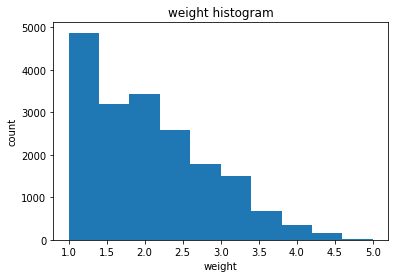

In [53]:
df_plot = bgg.loc[(bgg['weight'] != 0)]
_ = plt.hist(df_plot['weight'])
_ = plt.title('weight histogram')  
_ = plt.xlabel('weight')  
_ = plt.ylabel('count')  
plt.show()

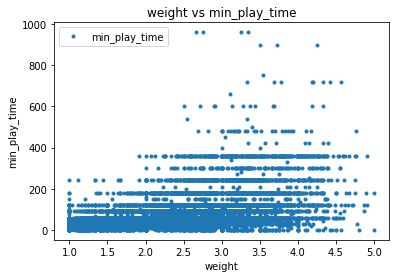

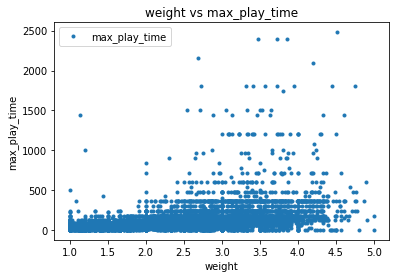

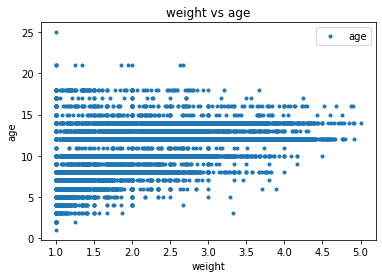

In [132]:
df_plot = bgg.loc[(bgg['weight'] != 0) & (bgg['min_play_time'] < 1000)]
_ = df_plot.plot(x='weight', y='min_play_time', style='.')  
_ = plt.title('weight vs min_play_time')  
_ = plt.xlabel('weight')  
_ = plt.ylabel('min_play_time')  
plt.show()

df_plot = bgg.loc[(bgg['weight'] != 0) & (bgg['max_play_time'] < 2500)]
_ = df_plot.plot(x='weight', y='max_play_time', style='.')  
_ = plt.title('weight vs max_play_time')  
_ = plt.xlabel('weight')  
_ = plt.ylabel('max_play_time')  
plt.show()

df_plot = bgg.loc[(bgg['weight'] != 0) & (bgg['age'] != 0)]
_ = df_plot.plot(x='weight', y='age', style='.')  
_ = plt.title('weight vs age')  
_ = plt.xlabel('weight')  
_ = plt.ylabel('age')  
plt.show()

It does not appear that weight has a linear relationship with age or play times. Are there other relationships that I can use?

In [240]:
bgg_no_zeroes = bgg.loc[(bgg != 0).all(1)]

In [171]:
corr = bgg_no_zeroes.corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,avg_rating,geek_rating,num_voters,rank,game_id,age,max_play_time,max_players,min_play_time,min_players,weight
avg_rating,1.000000,0.518649,0.190343,-0.755169,0.411140,0.334380,0.058295,-0.035150,0.030768,-0.145295,0.505478
geek_rating,0.518649,1.000000,0.633452,-0.718613,0.138334,0.194281,0.006623,-0.018829,0.002641,-0.072094,0.300907
num_voters,0.190343,0.633452,1.000000,-0.316091,-0.015357,0.048769,-0.003688,-0.002600,-0.005497,-0.008525,0.087418
rank,-0.755169,-0.718613,-0.316091,1.000000,-0.251763,-0.248188,-0.020002,0.020025,-0.010857,0.085159,-0.376742
game_id,0.411140,0.138334,-0.015357,-0.251763,1.000000,0.100264,-0.007713,0.010741,-0.053202,-0.103167,-0.031509
age,0.334380,0.194281,0.048769,-0.248188,0.100264,1.000000,0.059441,-0.011540,0.065361,0.015707,0.515374
max_play_time,0.058295,0.006623,-0.003688,-0.020002,-0.007713,0.059441,1.000000,-0.002778,0.456996,0.012839,0.110443
max_players,-0.035150,-0.018829,-0.002600,0.020025,0.010741,-0.011540,-0.002778,1.000000,-0.005041,0.080409,-0.080246
min_play_time,0.030768,0.002641,-0.005497,-0.010857,-0.053202,0.065361,0.456996,-0.005041,1.000000,0.052330,0.128843
min_players,-0.145295,-0.072094,-0.008525,0.085159,-0.103167,0.015707,0.012839,0.080409,0.052330,1.000000,-0.172115


Weight or other columns do not have a strong enough relationship to use in linear regression, so I'll use kNN imputation to fill in these values.

In [222]:
# subsetting numerical values from the bgg data set
X = bgg[['age', 'max_play_time','max_players','min_play_time','min_players','weight']]
imputer = KNNImputer(missing_values=0)

# create impute DF and merge with text values
bgg_impute = pd.DataFrame(imputer.fit_transform(X), columns=['age', 'max_play_time','max_players','min_play_time','min_players','weight'])
bgg_to_append = bgg[['avg_rating','geek_rating','num_voters','title','full_game_url','rank','game_id','category','mechanic','family']]
bgg_impute = pd.merge(bgg_to_append, bgg_impute, on=bgg_to_append.index)

In [223]:
#checking sample values to ensure merge is sucessful and the imputed data makes sense
bgg_impute.sample(5)

,key_0,avg_rating,geek_rating,num_voters,title,full_game_url,rank,game_id,category,mechanic,family,age,max_play_time,max_players,min_play_time,min_players,weight
10578,10592,6.22,5.539,75,Ochs & Esel,https://boardgamegeek.com/boardgame/37777/ochs...,10581,37777,'Card Game','Ladder Climbing',"'Animals: Cattle / Cows', 'Animals: Donkeys', ...",8.0,20.0,12.0,20.0,3.0,1.333000
13885,13899,6.17,5.514,47,Treachery in a Pocket,https://boardgamegeek.com/boardgame/227425/tre...,13888,227425,"'Card Game', 'Medieval', 'Renaissance'","'Area Majority / Influence', 'Hand Management'...",NaN,10.0,20.0,4.0,10.0,2.0,1.333008
1809,1813,7.81,6.143,590,The Guns of Gettysburg,https://boardgamegeek.com/boardgame/36400/guns...,1810,36400,"'American Civil War', 'Post-Napoleonic', 'Warg...","'Action Points', 'Area Movement', 'Secret Unit...","'Components: Block wargames', 'Crowdfunding: K...",13.0,180.0,4.0,180.0,2.0,3.736000
18972,18986,4.66,5.092,1216,Afrikan tähti,https://boardgamegeek.com/boardgame/5130/afrik...,18975,5130,"""Children's Game"", 'Exploration'","'Point to Point Movement', 'Roll / Spin and Move'","'Continents: Africa', 'Theme: Mining'",6.0,45.0,5.0,45.0,2.0,1.097000
10383,10397,6.10,5.541,113,Rabbit Hunt,https://boardgamegeek.com/boardgame/40602/rabb...,10386,40602,"'Animals', 'Bluffing', 'Card Game', 'Memory'","'Hand Management', 'Memory', 'Point to Point M...",'Animals: Rabbits',7.6,20.0,4.0,20.0,2.0,1.500000


### Category, Mechanic, Family

A non-trivial number of games have not been clasified in category, mechanic or family. At this time I do not want to remove the NaN values so they will remain as NaN.

### Cleaning up columns and saving the data

Saving both the data with zeroes dropped and imputed values to learn how modeling is affected by these different methods.

In [241]:
bgg_no_zeroes.rename(columns={"full_game_url": "url"}, inplace=True)
bgg_no_zeroes.to_csv('bgg_clean_no_zeroes.csv')

In [228]:
bgg_impute.rename(columns={"Full_game_url": "url"}, inplace=True)
bgg_impute.drop(columns='key_0', inplace=True)
bgg_impute.to_csv('bgg_clean_impute.csv')